In [1]:
import os
import shutil
import random
import math
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# DATA COLLECTING

sumber_dir = "Car-Bike-Dataset"
base_dir = "dataset_split"
classes = ['Car', 'Bike']

# Hitung jumlah dan cek kualitas
total_images = 0
class_stats = {}

for cls in classes:
    cls_path = os.path.join(sumber_dir, cls)
    files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    valid_count = 0
    for f in files:
        try:
            img = Image.open(os.path.join(cls_path, f))
            img.verify()
            valid_count += 1
        except:
            pass
    
    class_stats[cls] = valid_count
    total_images += valid_count

print(f"Total Images: {total_images}\n")
for cls, count in class_stats.items():
    print(f"{cls}: {count} ({count/total_images*100:.1f}%)")

counts = list(class_stats.values())
imbalance_ratio = max(counts) / min(counts)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

Total Images: 4000

Car: 2000 (50.0%)
Bike: 2000 (50.0%)

Imbalance Ratio: 1.00:1


In [4]:
# DATA SPLITTING

for subset in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, subset, cls), exist_ok=True)

train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15

for cls in classes:
    src = os.path.join(sumber_dir, cls)
    all_files = os.listdir(src)
    random.seed(42)
    random.shuffle(all_files)
    
    total = len(all_files)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)
    
    train_files = all_files[:train_count]
    val_files = all_files[train_count:train_count + val_count]
    test_files = all_files[train_count + val_count:]
    
    for f in train_files:
        shutil.copy(os.path.join(src, f), os.path.join(base_dir, 'train', cls, f))
    for f in val_files:
        shutil.copy(os.path.join(src, f), os.path.join(base_dir, 'val', cls, f))
    for f in test_files:
        shutil.copy(os.path.join(src, f), os.path.join(base_dir, 'test', cls, f))
    
    print(f"{cls}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

Car: Train=1400, Val=300, Test=300
Bike: Train=1400, Val=300, Test=300


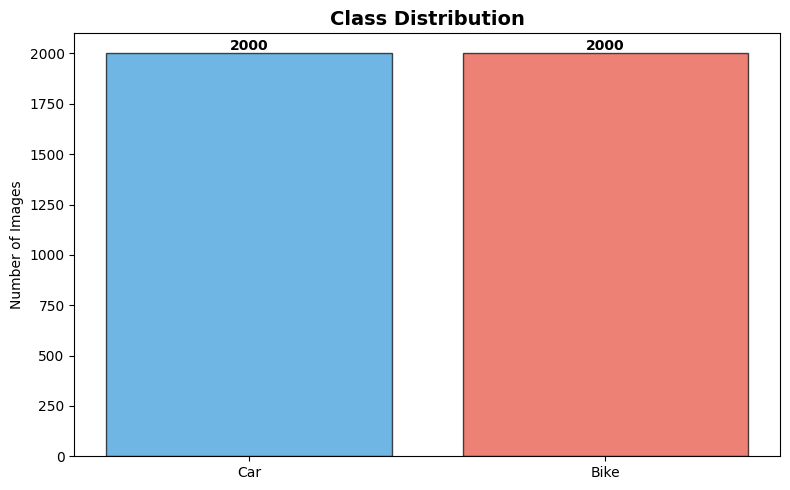

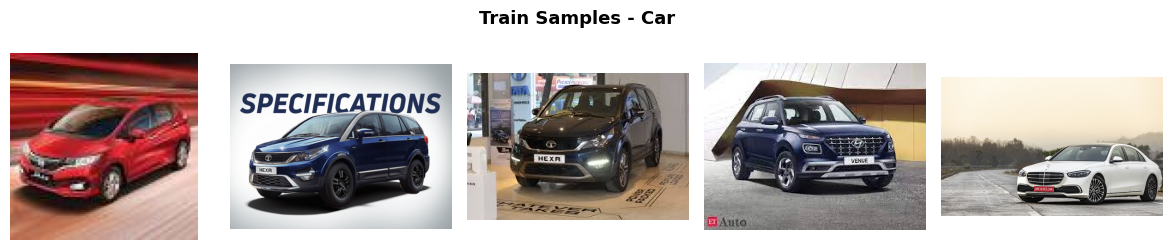

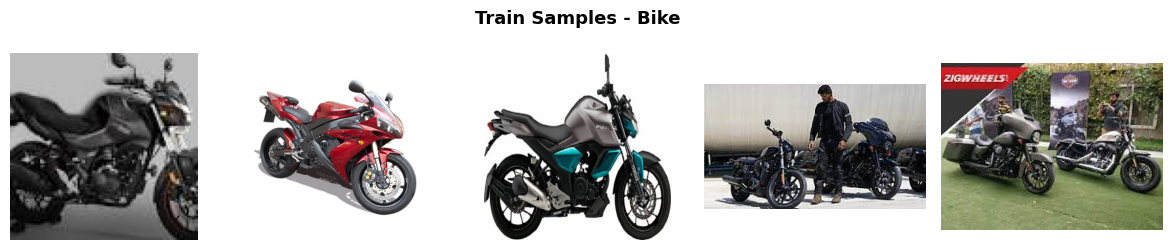

In [5]:
# DATA ANALYSIS & VISUALIZATION

# Visualisasi distribusi kelas
labels = list(class_stats.keys())
values = list(class_stats.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=['#3498db', '#e74c3c'], alpha=0.7, edgecolor='black')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

# Visualisasi sampel gambar
for cls in classes:
    folder_path = os.path.join(base_dir, 'train', cls)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]
    
    plt.figure(figsize=(12, 2.5))
    plt.suptitle(f'Train Samples - {cls}', fontsize=13, fontweight='bold')
    
    for i, img_name in enumerate(image_files):
        img = Image.open(os.path.join(folder_path, img_name))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


In [6]:
# DATA PREPROCESSING

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print(f"\nTrain: {train_generator.samples}, Val: {val_generator.samples}, Test: {test_generator.samples}")

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))


Found 2800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.

Train: 2800, Val: 600, Test: 600


In [7]:
# DATA MODELING

model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')
])

print("\nModel Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,308,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,403,329 (20.61 MB)

 Trainable params: 5,402,625 (20.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [8]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=5, 
                  restore_best_weights=True, 
                  verbose=1),
    
    ReduceLROnPlateau(monitor='val_loss', 
                      factor=0.5, 
                      patience=3, 
                      min_lr=1e-7, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

print(f"\nFinal Train Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Val Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Epoch 1/30
 6/88 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.5152 - loss: 1.2741

C:\Users\Zyrex\AppData\Roaming\Python\Python312\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.5964 - loss: 1.2024 - val_accuracy: 0.5000 - val_loss: 12.0505 - learning_rate: 0.0010
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 992ms/step - accuracy: 0.7004 - loss: 1.0420 - val_accuracy: 0.5000 - val_loss: 9.4152 - learning_rate: 0.0010
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7154 - loss: 0.9921 - val_accuracy: 0.5583 - val_loss: 2.9844 - learning_rate: 0.0010
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.7696 - loss: 0.8659 - val_accuracy: 0.6467 - val_loss: 3.7635 - learning_rate: 0.0010
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 982ms/step - accuracy: 0.7839 - loss: 0.8253 - val_accuracy: 0.6683 - val_loss: 1.7021 - learning_rate: 0.0010
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 88s 999ms/step - accuracy: 0.8061 - loss: 0.7776 - val_accuracy: 0.7900 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 87s 982ms/step - accuracy: 0.8129 - loss: 0.7713 - val_accurac


Test Accuracy: 0.9483 (94.83%)
Test Loss: 0.3675

Classification Report:
              precision    recall  f1-score   support

        Bike       0.97      0.93      0.95       300
         Car       0.93      0.97      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



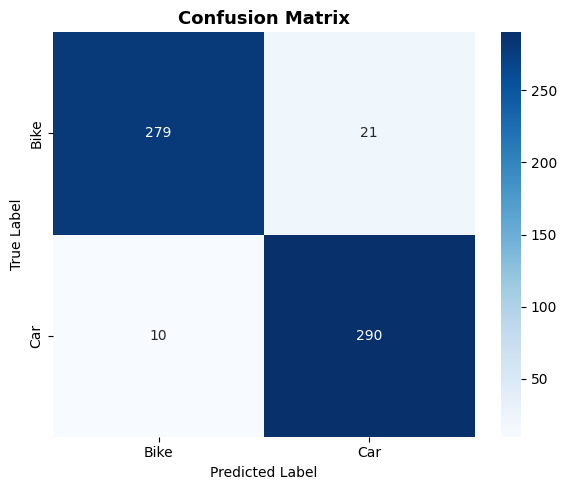

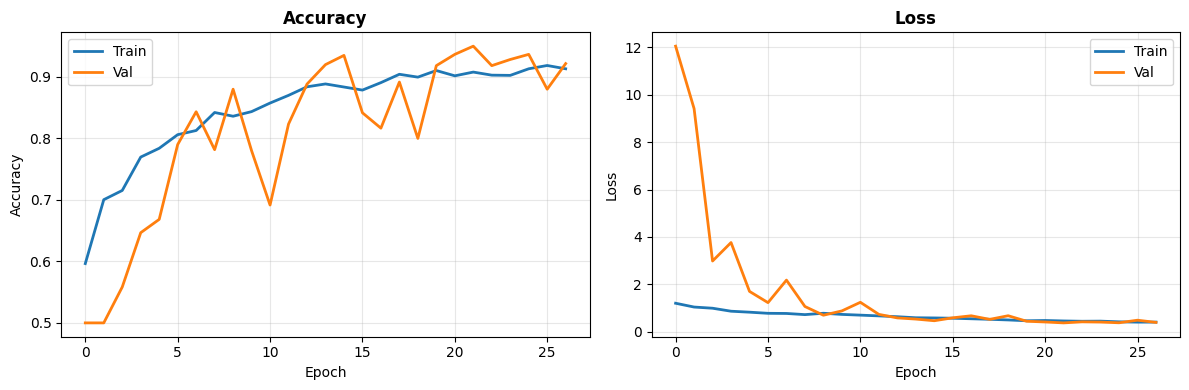

In [9]:
# EVALUATION

test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Bike', 'Car']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bike', 'Car'], yticklabels=['Bike', 'Car'])
plt.title('Confusion Matrix', fontsize=13, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Val', linewidth=2)
ax1.set_title('Accuracy', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Val', linewidth=2)
ax2.set_title('Loss', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# EXPORT MODEL

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

class_indices = train_generator.class_indices
sorted_labels = sorted(class_indices.items(), key=lambda x: x[1])

with open('labels.txt', 'w') as f:
    for label, idx in sorted_labels:
        f.write(f"{idx} {label}\n")

print(f"Model saved: model.tflite ({len(tflite_model)/1024:.2f} KB)")
print("Labels saved: labels.txt")

print(f"\nFiles saved to: {os.getcwd()}")
print("- model.tflite")
print("- labels.txt")

print("COMPLETED!")

INFO:tensorflow:Assets written to: C:\Users\Zyrex\AppData\Local\Temp\tmpbn4ptahe\assets


INFO:tensorflow:Assets written to: C:\Users\Zyrex\AppData\Local\Temp\tmpbn4ptahe\assets


Saved artifact at 'C:\Users\Zyrex\AppData\Local\Temp\tmpbn4ptahe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2013585914384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013585915728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013585914192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013585915152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013585915344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013585913232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013585914768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013625418384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013625418000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2013625418768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  20135